In [1]:
#Basic shit
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

#Gurobi
import gurobipy as gp
from gurobipy import GRB

# Relevant example

## Pre-study
As an initial study: set up a simple model of such a transportation network. It does not have to be full size and  it does not have to use specific data. The data can be replaced later, but the range and speed of drones should be less than that of the electric aircrafts so the set up makes sense.

You should do a literature review to better understand the problem setting, know about related studies, and get an idea of what tools and models have been applied for similar studies.

Relevant questions that you should consider are

* could the network you have set up, with the assumed performance of the vehicles, provide service to all citizens of your model of Sweden?
* for a given origin - destination pair, can you compute the best transport route connecting them?
* for the assumed demand, can you give a rough estimate on the number of vehicles that would be needed?

## Fleet Assignment
In Fleet assignment we assume there is a flight schedule and a set of aircrafts.
The assignment problem is to maximize the profitablity of the flight plan by choosing which aircraft type should operate each flight.
Profitability depends on the costs for operating a flight with a certain type of aircraft, and costs for spilled customers (if the capacity of assigned aircraft is too small) and spoiled seats (if the capacity of the aircraft is too high).
Several operational constraints may be present, usually of a technical nature, such as gate compatibility, maintenance, et.c..
Preferrably take into account if the intended aircraft is available.


Well, unlike most fleet assignment problems 
* We do not actually have any initial limitations on the size of our fleet;
* We do not have a set schedule/flight-plan
* No idea about operational constraints


Instead our initial step would probably be to construct an optimal itenerary. 

## Optimal Itenerary
Basically see what current legs could be substituted with Elecric Aircrafts or Drones (EAD), without our system becoming worse. Of course in relation to what? Or rather; optimal how?

* Cash money; Hard, since we have no idea regarding costs
* Time; Would probably result in a model that's too expensive
* Environment; Might be good, but also very complex


Suggestions
* have a limited number of EAD's and see where adding them would be the best time-wise
* have a limited number of potential hubs and see where adding them would be the best time-wise
* other...

## Regardless
Ok, I already wrote all that but honestly, I think that we should look into schedule planning, because that's waay more relevant to us

## CAB

https://andreas-ernst.github.io/Mathprog-ORlib/info/readmeAP.html

Civil Aeronautics Board (CAB) Hub Location Instances ==================================================================================

This is really just a 25 node instance with smaller instances created by taking the first n nodes (typically for n=10,15 & 20) and by varrying the transfer cost (typically 0.2 to 1.0 in steps of 0.2). These instances have been contributed to the research community by M.E. O’Kelly.

This is the 25 node data set that has been used extensively with hub and spoke location models. It is sometimes referred to as the CAB data set. Full references to the source and prior results for these data can be found in several previous paper, including

* O’Kelly, Morton E. “A quadratic integer program for the location of interacting hub facilities.” European Journal of Operational Research 32, no. 3 (1987): 393-404.
* O’Kelly, Morton E., Deborah Bryan, Darko Skorin-Kapov, and Jadranka Skorin-Kapov. “Hub network design with single and multiple allocation: A computational study” Location Science 4, no. 3 (1996): 125-138.


In [59]:
with open('Data/CAB/25.3.4') as f:
    CAB = f.read().splitlines()
nodes = int(CAB[0])
CAB = CAB[1::]
coords = []
for i in range(nodes):
    coords.append(Point(CAB[i].split(" ")))
CAB = CAB[nodes::]
df = pd.DataFrame()
for i in range(nodes):
    df[i] = [float(x) for x in CAB[i].split(" ")]    
CAB = CAB[25::]
df["geometry"] = coords

gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs('EPSG:32120', inplace=True)

for i in range(nodes):
    gdf[i] = gdf.distance(gdf.geometry[i]) 
gdf["total_flow"] = df.sum(axis=1, numeric_only=True)

num_hubs = float(CAB[0])
chi = float(CAB[1])
alpha = float(CAB[2])
delta = float(CAB[3])
print("number of hubs =", num_hubs)
print("collection cost =", chi)
print("transfer cost =", alpha)
print("distribution cost =", delta)

number of hubs = 3.0
collection cost = 1.0
transfer cost = 0.4
distribution cost = 1.0


df is the flow between nodes and gdf is the distance
gdf also contains two additional columns: 
* geometry, which denotes the coordinates for each node
* total flow, which denotes the the total flow for the airport

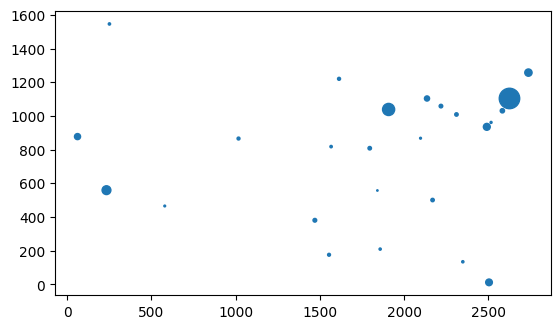

In [3]:
#Note that flow is exaggerated here for plotting purposes (by a power of 2, which might be OK because of 2d?)
gdf.plot(markersize=(gdf["total_flow"]/gdf["total_flow"].min())**2)

plt.show()

## what should we do?
(EAD = electric aricrafts or drones)


There are some alternatives as to what we could focus on. 
I think the stuff we have covered so far is mostly on the wrong time-scale. We probably want to consider a larger (planning) time scale.

Some options:
### Hub and spoke analysis: 
* current hubs
* what airports could be considered (additional) hubs with the additions of EAD?
* how would this effect travel time?

(maybe allow only one type of plane on smaller airports - so that choosing EAD incurrs a penalty)

### Northern hub: make Norrland smaller
A look at how we could make Norrland more connected by implementing a network of electrical aircrafts in northern Sweden.
* compute data on travel times for all/most places in norrland
* see how well this actually adheres to current goals
* Optimize something

### Replace non-airplane travel with electrical planes/drones
* Lorem Ipsum

### Fleet assignment
Here we would basically see if any current planes could be replaced with EADs
* preform fleet assignment for current schedule, but include EADs

### Fast and Fucking expensive
Restrict problem to only travel time in some way


### Environmental impact
Problem formulation centering on making domestic travel as environmentally friendly as possible


## We need
regardless we will need to come up with some numbers for

We need to come up with:
* max radius for EAD
* max passengers for EAD
* flight speed for EAD

Hopefully we might get:
* everything above for current aircrafts (limit to one type? depends on what we choose to do)
* current data (will limit which of the above are doable)
* demands (accessability goals etc)
* current schedules (needed for some of the suggested projects)

Other stuff (which contains uncertainty)
* Cost of running EAD
* Cost of opening up hubs
* environmental metrics
* max capacity of airports
* alternative international airports ()


In [5]:
D = gdf.drop(columns=["geometry", "total_flow"]).to_numpy()
W = df.drop(columns=["geometry"]).to_numpy()
C = 0.1*D
J = len(W)
J_idx = [j for j in range(J)]
F = [10000000 for j in J_idx]
A = np.array([[1 for j in J_idx] for i in J_idx])

ij_tup = [(i,j) for i in J_idx for j in J_idx]
ijk_trip = [(i,j,k) for i in J_idx for j in J_idx for k in J_idx]


OD = [sum(w_i) for w_i in W]
DD = [sum(w_i) for w_i in W] #symmetric

In [6]:
#model
try:
    m = gp.Model("airfleet")
    
    ###Variables:
    
    z = m.addVars(ij_tup, vtype=GRB.BINARY, name="Z") 
    y = m.addVars(ijk_trip, name="Y") 

    
    open_hub = sum(F[k]*z[k,k] for k in J_idx) 
    btw_hubs = alpha*sum(sum(sum(C[k,l]*y[k,l,i] for i in J_idx) for k in J_idx) for l in J_idx)
    spokes = sum(sum(C[i,k]*(chi*OD[i]+delta*DD[i])*z[i,k] for i in J_idx) for k in J_idx)
    
    obj = open_hub + btw_hubs  + spokes 
    
    
    ###Model
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)
    
    #constraints that help define the variables u(v) in the objective function
    
    m.addConstrs((z[i,k] <= A[i,k]*z[k,k] for i in J_idx for k in J_idx), "2")
    
    m.addConstrs((sum(z[i,k] for k in J_idx)==1 for i in J_idx), "3")
    
    m.addConstrs((OD[i]*z[i,k] == sum(W[i,j]*z[j,k] for j in J_idx) + sum(y[k,l,i] for l in J_idx) - sum(y[l,k,i] for l in J_idx) for i in J_idx for k in J_idx), "4")
    
    # for i in J_idx:
    #     for k in J_idx:
    #         temp_idx = [l for l in J_idx if l!=k]
    #         m.addConstr(sum(y[k,l,i] for l in temp_idx) <= OD[i]*z[i,k])
        
    
    m.addConstrs((sum(y[k,l,i] for l in J_idx if l != k) <= OD[i]*z[i,k] for i in J_idx for k in J_idx), name="5")
    
    
    
    m.optimize()
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-02


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1900 rows, 16250 columns and 63075 nonzeros
Model fingerprint: 0x0f09f929
Variable types: 15625 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 7e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 50 rows and 1225 columns
Presolve time: 0.88s
Presolved: 1850 rows, 15025 columns, 60650 nonzeros
Variable types: 14400 continuous, 625 integer (625 binary)
Found heuristic solution: objective 1.373408e+09

Root relaxation: objective 5.249409e+08, 1144 iterations, 0.08 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5.2494e+08    0   24 1.3734e+09 5.2494e+08  61.8%     -    1s
H    0     0  

In [7]:
z = np.array(m.getAttr("X", z.values())).reshape((J,J))
z = z.round(1)

In [8]:
#Find value 1 for each row (representing the corresponding hub)
gdf["hub"] = np.argmax(z, axis=1)
gdf["hub"]

0      0
1     24
2      2
3      3
4      5
5      5
6      6
7      7
8      5
9      6
10    20
11    11
12    20
13    13
14    14
15    15
16    16
17    16
18    11
19     5
20    20
21    21
22    22
23    13
24    24
Name: hub, dtype: int64

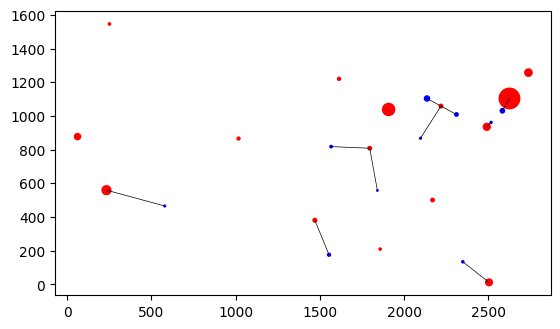

In [9]:
#Plot nodes with edges with the hubs
gdf.plot(column=gdf.index == gdf["hub"], markersize=(gdf["total_flow"]/gdf["total_flow"].min())**2, colormap="bwr")
# now connect the hubs with lines
for i in range(len(gdf)):
    plt.plot([gdf.geometry[i].x, gdf.geometry[gdf["hub"][i]].x], [gdf.geometry[i].y, gdf.geometry[gdf["hub"][i]].y], color="black", linewidth=0.5)

In [10]:
y = np.array(m.getAttr("X", y.values())).reshape((J,J,J))
y = y.round(1)

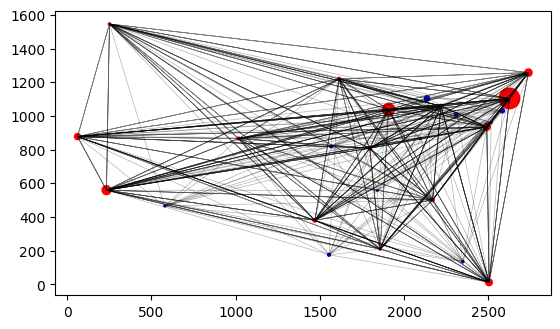

In [11]:
#Plot nodes with edges with the hubs
gdf.plot(column=gdf.index == gdf["hub"], markersize=(gdf["total_flow"]/gdf["total_flow"].min())**2, colormap="bwr")
# now connect the legs with lines
for i,j,k in np.transpose((y!=0).nonzero()):
    plt.plot([gdf.geometry[i].x, gdf.geometry[j].x, gdf.geometry[k].x], [gdf.geometry[i].y, gdf.geometry[j].y, gdf.geometry[k].y], color="black", linewidth=0.5, alpha=0.3)

Are there flight (spoke to spoke) which would be cheaper using urban air mobility aircrafts instead of taking to flights.

In [42]:
legs = pd.DataFrame([[k,l,i] for k,l,i in np.transpose((y!=0).nonzero()) if i != k], columns=["k", "l", "i"])
legs["distance"] = [ gdf[k][l] + gdf[i][k] for k,l,i in zip(legs["k"], legs["l"], legs["i"])]]

,k,l,i,distance
0,5,0,4,785.663012
1,5,0,8,654.026337
2,5,0,19,664.415305
3,5,2,4,781.966211
4,5,2,8,650.329536
...,...,...,...,...
135,24,15,1,999.538350
136,24,16,1,252.055684
137,24,20,1,742.997150
138,24,21,1,2466.763474
